<a href="https://colab.research.google.com/github/NelsonXunic/compsci_guides/blob/master/L02_2_Opt_f22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [L02: Implementing 2-Opt TSP](https://docs.google.com/document/d/1JA_CWBXPN6whvJAemnJLvtYJ3Pbk84dTUolWO_QqosA/edit?usp=sharing)
Written by Dr. Jan Pearce, Berea College

Complete the code by meeting all linked requirements and fixing all FIXMEs

## Your Name: FIXME

**SUMMARY**: A brief summary description of the design and implementation, including how much your initial design plan evolved, the final result you achieved and the amount of time you spent as a programmer or programmers in accomplishing these results. This should be no more than two paragraphs.

FIXME

**PERSONNEL**: A description of who you worked with and on what sections.  It is expected that all collaboration is done as pair programming together. Also, note these collaborations in the code section itself.

FIXME

**CHALLENGES**: Descriptions of the largest challenges you overcame and what made them challenging.

FIXME

**INNOVATIONS**: Any innovations that were not specifically required by the assignment. These are not required, but should be highlighted if included.

FIXME

**TESTING**: Describe how you tested this work.

FIXME

**ERRORS**: A list in bulleted form of all known errors and deficiencies.

FIXME

**COMMENTS**: A paragraph or so of your own comments on and reactions to the Lab. 

FIXME

## Import Libraries

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import random
from urllib.request import urlopen

### Read data

In [ ]:
def get_new_node_coords(numnodes, scale=1):
    """
    Create a new graph with numnodes nodes.
    Arguments:
        numnodes {int} -- number of nodes for your graph
    Keyword Arguments:
        scale {int} -- larger numbers squeeze nodes into a smaller space
    """
    nodeStr = f'{numnodes}\n'
    coords = []
    for i in range(numnodes):
        x, y = random.randint(1, numnodes//scale), random.randint(1, numnodes//scale)
        while (x, y) in coords:
            x, y = random.randint(1, numnodes//scale), random.randint(1, numnodes//scale)
        coords.append((x, y))
        nodeStr += f'{x} {y}\n'
    return nodeStr
    

# tspdata = urlopen("http://cs.berea.edu/courses/csc445/data/tsp-48.txt").read().decode('ASCII')
# tspdata = urlopen("http://cs.berea.edu/courses/csc445/data/tsp-small.txt").read().decode('ASCII')
tspdata = get_new_node_coords(20)
print(tspdata)

20
2 13
9 7
20 20
1 8
18 13
10 2
16 17
7 13
11 12
3 11
1 11
6 11
5 2
9 6
19 18
8 7
3 10
18 12
16 1
12 1



## TSP Class

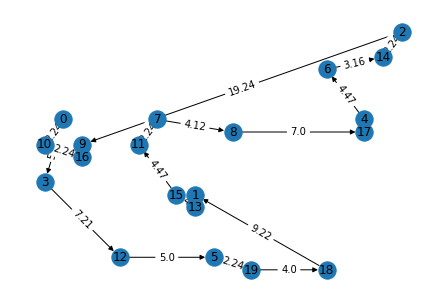

In [ ]:
"""

Given certain input, it uses the 2-opt algorithm to plot a graph and output a file of the solution path
"""

class TSP:

    def __init__(self):
        """ TSP class containing data needed for networkx graph creation, file reading and file writing. 
            Creates a graph for the traveling salesperon problem using the 2-opt algorithm
        """
        self.graph = nx.DiGraph()    # Graph object
        self.nodeData = []           # Stores node coordinates as list
        self.coords = {}             # Stores node coordinates as dict
        self.route = []              # Stores route as list of ints

    def extractData(self, inputFile=""):
        """
        Iterate through the input file and append each coordinate into the node list.
        Keyword Arguments:
            inputFile {str} -- a string for the file name (default: {""})
        """
        WTSPC = ['\n', '\r', '\t', ' ']
        inputData = inputFile.split()
        cleanData = [int(i) for i in inputData if i not in WTSPC]

        self.dimension = cleanData[0]

        for i in range(1, len(cleanData), 2):
            nodeX = cleanData[i]
            nodeY = cleanData[i + 1]
            self.nodeData.append([nodeX, nodeY])

    def setUpCoords(self):
        """ Puts the coordinates for each node into a dictionary as a tuple with the node as the key """
        for i in range(len(self.nodeData)):
            self.coords[i] = self.nodeData[i]

    def calculateDistance(self, a, b): 
        """calculates & returns the distance between points a and b
        Arguments:
            a {[tuple]} -- tuple of numbers for the x and y coordinate of a node
            b {[tuple]} -- tuple of numbers for the x and y coordinate of a node
        Returns:
            [float] -- the distance between the two points using the distance formula
        """
        x1 = float(a[0])
        y1 = float(a[1])
        x2 = float(b[0])
        y2 = float(b[1])
        xSquared = math.pow(x2 - x1, 2)
        ySquared = math.pow(y2 - y1, 2)

        # Round off for clarity when displaying edges
        c = round(math.sqrt(xSquared + ySquared), 2)
        return c

    def getGreedyRoute(self, start): 
        """Builds a route using the Greedy algorithm
           Stores route in self.route
        Arguments:
            start {int} -- the node to start at, not a list index
        """
        self.route = [start]
        nVisited = [i for i in self.graph.nodes() if i != start]
        current = start
        while nVisited:
            distances = {i: self.calculateDistance(self.coords[current], self.coords[i]) for i in nVisited}
            minDist = 1000000000000
            closestNode = -1
            for node in distances:
                if distances[node] < minDist:
                    minDist = distances[node]
                    closestNode = node
            self.route.append(closestNode)
            nVisited.remove(closestNode)
            current = closestNode
        self.route.append(start)

    def getDirection(self, a, b, c):
        """Helper method for self.edgesCrossing
        Arguments:
            a {tuple (int, int)} -- The first endpoint of the first line
            b {tuple (int, int)} -- The second endpoint of the first line
            c {tuple (int, int)} -- An endpoint of the second line
        """
        ax, ay = self.coords[a][0], self.coords[a][1]
        bx, by = self.coords[b][0], self.coords[b][1]
        cx, cy = self.coords[c][0], self.coords[c][1]
        val = (by-ay)*(cx-bx)-(bx-ax)*(cy-by)
        if val < 0:
            return -1
        elif val > 0:
            return 1
        return 0

    def edgesCrossing(self, e1, e2):
        """Determines if edges e1 and e1 cross
        Arguments:
            e1 {tuple (int, int)} -- The first edge
            e2 {tuple (int, int)} -- The second edge
        Returns True if edges cross, False otherwise
        """
        a, b = e1[0], e1[1]
        c, d = e2[0], e2[1]

        if (a == c or a == d) or (b == c or b == d):
            return False

        dir1 = self.getDirection(a, b, c);
        dir2 = self.getDirection(a, b, d);
        dir3 = self.getDirection(c, d, a);
        dir4 = self.getDirection(c, d, b);

        if dir1 != dir2 and dir3 != dir4:
            return True
        return False

    def getCrossingEdges(self, start):
        """Creates a list of all pairs of edges that cross
        Arguments:
            start {int} -- The starting node
        Returns list of edge pairs [ (e1, e2), (e3, e4), ... ]
          where e1 = (int, int), e2 = (int, int), etc...

          to be completed in L02
        """
        pass

        #FIXME complete this function
        # Remember, you will want to ignore any edges with 'start' as an endpoint.

    def twoOpt(self, start): 
        """ puts together the 2-opt algorithm. Gets the route order and adds the starting place to the end of the route
        Arguments:
            start -- the starting node for the two-Opt algorithm

            to be completed in L02
        """
        pass

        #FIXME complete this function

    def twoOptSwap(self, e1, e2):
        """ performs a single swap on a pair of edges, and handles all additional
               tasks involved in the swap
            e1 {tuple (int, int)} -- The first edge
            e2 {tuple (int, int)} -- The second edge

            to be completed in L02
        """
        pass

        #FIXME complete this function
    
    def calculateTotalDistance(self):
        """ calculates the total distance of the current route

        Return calculated distance

            to be completed in L02
        """
        pass

        #FIXME complete this function

    def addNodes(self): 
        """ adds nodes to the networkx graph
        """

        for node in self.coords:
            self.graph.add_node(node, pos=self.coords[node])

    def addEdges(self): 
        """Adds graphs to the networkx graph
        """

        x = 0
        while x < len(self.route)-1:
            self.graph.add_edge(self.route[x], self.route[x+1],
                                weight=self.calculateDistance(self.coords[self.route[x]], self.coords[self.route[x+1]]))
            x += 1

    def showGraph(self):
        """Uses the imported libraries to display the graph
        """
        # get labels and coordinates for the graph
        coords = nx.get_node_attributes(self.graph, 'pos')
        labels = nx.get_edge_attributes(self.graph, 'weight')
        # draw nodes in their coordinates
        nx.draw(self.graph, coords)
        nx.draw_networkx_labels(self.graph, coords)
        # draw edges with their weights
        nx.draw_networkx_edge_labels(self.graph, coords, edge_labels=labels)
        plt.show()




def main():
    tsp = TSP()

    tsp.extractData(tspdata)
    tsp.setUpCoords()
    tsp.addNodes()
    tsp.getGreedyRoute(1) # feel free to use your solution from L01
    tsp.addEdges()
    tsp.twoOpt(1)
    tsp.showGraph()


main()

## Integrity statement
Please briefly describe all references you used, all help you received, and all help you gave to others in completing this assignment. Be sure to say that you got no help if you got none.